# In this notebook we will be trying the transformer architecture
This choice is motivated by the fact that the transformer excels at seqtoseq, and is able to capture dependencies spatially and temporally. I hypothesize that this is a good fit for the task since ECOG data is very complex and has dependencies in both time and space.

## Imports

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import math
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint



In [13]:
def calculate_vectors(coords, resolution):
    """
    Calculate the average vectors of x and y magnitudes given a resolution.

    Parameters:
    coords (list of tuples): An array of (x, y) coordinates.
    resolution (int): The resolution number.

    Returns:
    list of tuples: An array of vectors of x and y magnitudes.
    """
    if resolution <= 0:
        raise ValueError("Resolution must be a positive integer.")
    
    n = len(coords)
    if resolution > n:
        raise ValueError("Resolution cannot be greater than the length of the coordinates array.")
    
    # Calculate the segment length
    segment_length = n // resolution
    
    vectors = []
    
    for i in range(0, n, segment_length):
        segment = coords[i:i + segment_length]
        if len(segment) < segment_length:
            break
        
        # Calculate the average change in x and y
        delta_x = np.mean([segment[j+1][0] - segment[j][0] for j in range(len(segment) - 1)])
        delta_y = np.mean([segment[j+1][1] - segment[j][1] for j in range(len(segment) - 1)])
        
        vectors.append((delta_x, delta_y))
    
    return vectors

## Data Processing

In [14]:
resolution = 5000
def vectorize_joystick_readings(x, y, resolution):
     return calculate_vectors(list(zip(x, y)), resolution)

    

In [15]:
def ica(X, n_components):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_, A_

In [16]:
def load_jstick_data():
    # Load and preprocess data
    fname = './data/joystick_track.npz'
    alldat = np.load(fname, allow_pickle=True)['dat']
    dat = alldat[0]
    patient_idx = 1
    d = dat[patient_idx]
    # ecog
    ecog_data = d['V'] # Add batch and sequence length dimensions
    ecog_data = PCA(n_components=0.95).fit_transform(ecog_data)
    # magnitudes
    targetX = d['cursorX']
    targetY = d['cursorY']
    print(ecog_data.shape, targetX.shape, targetY.shape)
    resolution = 500
    vectors = np.array(vectorize_joystick_readings(targetX, targetY, resolution))
    print(vectors.shape)
    # match ecog to resolution by grouping, ensuring last sample is not empty
    ecog_data = [ecog_data[i:i+len(vectors)] for i in range(0, len(ecog_data), len(ecog_data)//len(vectors)) if i+len(vectors) <= len(ecog_data)]
    print(len(ecog_data[0]),len(ecog_data[-1]))
    ecog_data = np.array(ecog_data) 
    return ecog_data, vectors

(248640, 28) (248640, 1) (248640, 1)
(500, 2)
500 500


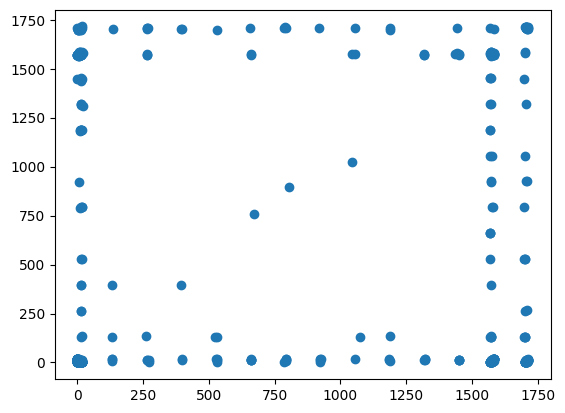

In [17]:
ecog_data, magnitudes = load_jstick_data()
plt.figure()
plt.scatter([x[0] for x in magnitudes], [x[1] for x in magnitudes])

## 


## Data Augmentation

In [18]:
# Split data into training and testing
# train test
train_test_split = 0.8
train_size = int(train_test_split * len(ecog_data))
X_train = ecog_data[:train_size]
X_test = ecog_data[train_size:]
y_train = magnitudes[:train_size]
y_test = magnitudes[train_size:]
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(400, 500, 28) (100, 500, 28) 400 100


## Transfromers: robots in disguise

In [19]:
print(torch.cuda.is_available())
torch.set_default_device('cuda') if torch.cuda.is_available() else torch.set_default_device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [20]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class ECoGTransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout_rate=0.1):
        super(ECoGTransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = checkpoint(self.transformer_encoder, x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])
        return x


In [22]:
# Example hyperparameters
input_dim = X_train.shape[-1]
model_dim = 256
num_heads = 8
num_layers = 6
output_dim = 2 
dropout_rate = 0.48411131648232686
learning_rate = 1e-2

# quantize the model
model = ECoGTransformerEncoder(input_dim, model_dim, num_heads, num_layers, output_dim)

# Training loop with mixed precision and gradient checkpointing
scaler = GradScaler()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 1000
scheduler = StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)



c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


'model_dim': 512, 'num_heads': 8, 'num_layers': 6, 'dropout_rate': 0.48411131648232686, 'learning_rate': 0.0008203239127338236

In [23]:
# Data normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

In [24]:
# real data

input_tensor = X_train
target_tensor = y_train
dataset = TensorDataset(input_tensor, target_tensor)
generator = torch.Generator(device=device)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)

In [25]:
print(X_train.shape, y_train.shape)
train = False
if train:
    model.train()
    for epoch in range(num_epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

torch.Size([400, 500, 28]) torch.Size([400, 2])


## Optuna, the hyperparameter optimizer

In [26]:
# run optuna?
run_optuna = True
import optuna
import torch
import torch.nn as nn



# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    model_dim = trial.suggest_categorical('model_dim', [128, 256, 512])
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])
    num_layers = trial.suggest_int('num_layers', 4,8)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    
    # real data
    input_tensor = X_train
    target_tensor = y_train
    dataset = TensorDataset(input_tensor, target_tensor)
    generator = torch.Generator(device=device)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)
    
    # Model and optimizer
    model = ECoGTransformerEncoder(input_dim=X_train.shape[-1], model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, output_dim=2, dropout_rate=dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    # Training loop
    for epoch in range(100):
        for data, target in dataloader:
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    return loss.item()

if run_optuna:
    # Run the optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Best hyperparameters
    print(study.best_params)

[I 2024-07-22 23:10:27,100] A new study created in memory with name: no-name-830fae97-22ad-4d3d-a327-601209c26ffb
C:\Users\thewa\AppData\Local\Temp\ipykernel_6912\1910652630.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\thewa\miniconda3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be pa

KeyboardInterrupt: 

best trial with output dim 1: [I 2024-07-22 11:58:14,634] Trial 15 finished with value: 753723.5625 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 5, 'dropout_rate': 0.2259481444219587, 'learning_rate': 0.0009022268315380955}. Best is trial 15 with value: 753723.5625.

wrong output dim, trying 2.
best: {'model_dim': 512, 'num_heads': 8, 'num_layers': 6, 'dropout_rate': 0.48411131648232686, 'learning_rate': 0.0008203239127338236}